In [62]:
import csv
import os
from random import sample

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [63]:
has_cuda = torch.cuda.is_available()
if has_cuda:
    print(torch.cuda.get_device_name(0))
else:
    print("Cuda unavailable")

device = torch.device("cuda" if has_cuda else "cpu")
print("Device:", device)

transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

Cuda unavailable
Device: cpu


# Helper Classes

In [64]:
class CancerDataset(Dataset):
    """
    Custom dataset for cancer detection.

    Args:
        csv_file (str): Path to the CSV file containing image filenames and labels.
        root_dir (str): Directory where the images are stored.
        transform (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Initializes the CancerDataset.

        Args:
            csv_file (str): Path to CSV file with labels.
            root_dir (str): Directory containing image files.
            transform (callable, optional): Transform to apply to the images.
        """
        self.labels_df = pd.read_csv(csv_file)  # Read the CSV file
        self.root_dir = root_dir  # Directory with all the images
        self.transform = transform  # Transformations for the images

    def __len__(self):
        """
        Returns the total number of samples.

        Returns:
            int: Number of samples.
        """
        return len(self.labels_df)  # Return total number of samples

    def __getitem__(self, idx):
        """
        Retrieves a sample by index.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, label), where image is the transformed image and label is the target label.
        """
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0] + '.tif')
        image = Image.open(img_name).convert('RGB')
        label = self.labels_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# EDA

In [65]:
data = pd.read_csv('data/train_labels.csv')

In [66]:
def show_images_with_labels(images, labels, nrow=8):
    images = images / 2 + 0.5  # Unnormalize
    fig, axes = plt.subplots(2, nrow, figsize=(12, 6))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axes[i // nrow, i % nrow]  # Arrange in grid
        ax.imshow(img.permute(1, 2, 0))  # Rearrange dimensions for display
        ax.set_title(f'Label: {label.item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Function to filter and show images by label
def show_images_by_label(images, labels, label_value, n_samples=8):
    filtered_indices = [i for i, lbl in enumerate(labels) if lbl == label_value]
    random_indices = sample(filtered_indices, n_samples)
    sampled_images = images[random_indices]
    sampled_labels = labels[random_indices]
    return sampled_images, sampled_labels

In [67]:
# Display basic info and statistics
print(data.info())  # Shows column types and non-null values
print(data.describe())  # Shows basic statistics for numeric columns
print(data['label'].value_counts())  # Count of each class (0 or 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
label
0    130908
1     89117
Name: count, dtype: int64


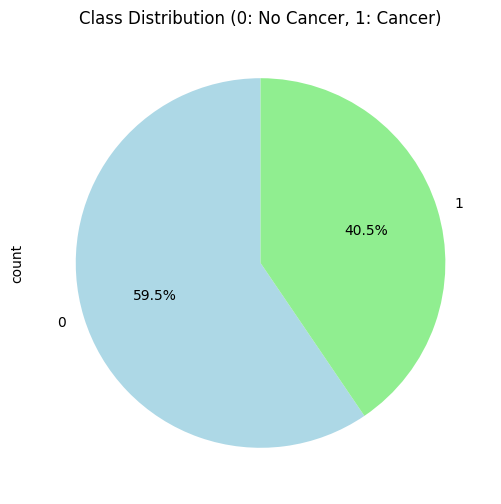

In [68]:
# Class distribution plot (Pie)
plt.figure(figsize=(6, 6))
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title('Class Distribution (0: No Cancer, 1: Cancer)')
plt.show()

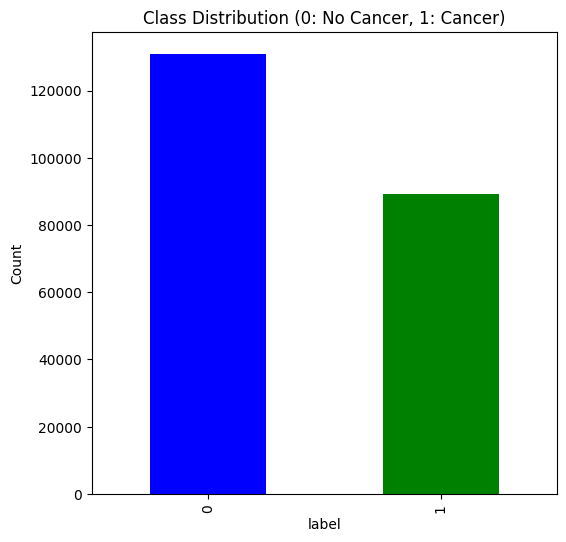

In [69]:
# Class distribution plot (Bar)
plt.figure(figsize=(6, 6))
data['label'].value_counts().plot(kind='bar', color=['blue', 'green'])
plt.title('Class Distribution (0: No Cancer, 1: Cancer)')
plt.ylabel('Count')
plt.show()

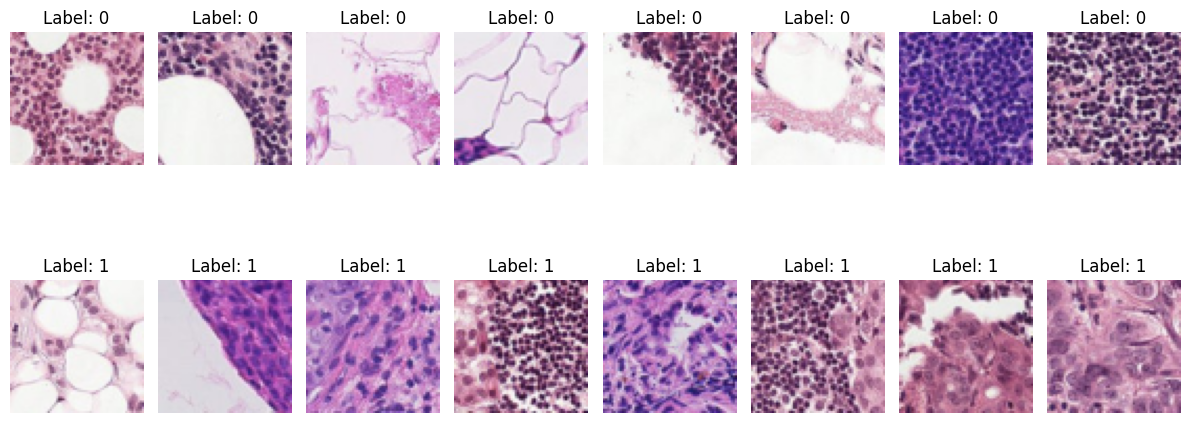

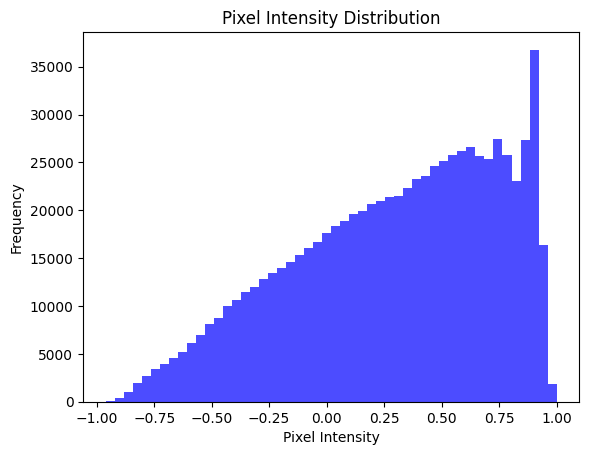

In [70]:
# Load a few samples from the dataset
train_dataset = CancerDataset(csv_file='data/train_labels.csv', root_dir='data/train', transform=transform)
loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Get a batch of images and labels
images, labels = next(iter(loader))

# Sample 8 images where label == 1 and 8 images where label == 0
images_label_0, labels_label_0 = show_images_by_label(images, labels, label_value=0, n_samples=8)
images_label_1, labels_label_1 = show_images_by_label(images, labels, label_value=1, n_samples=8)

# Concatenate and display
images_concat = torch.cat((images_label_0, images_label_1), 0)
labels_concat = torch.cat((labels_label_0, labels_label_1), 0)
show_images_with_labels(images_concat, labels_concat)

# Distribution of pixel intensities for a few sample images
sample_images, _ = next(iter(loader))  # Take one batch of images
sample_images = sample_images.view(-1).numpy()  # Flatten the images
plt.hist(sample_images, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Model Creation

In [71]:
class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) for binary classification of images.

    This CNN consists of three convolutional layers followed by fully connected layers.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        conv3 (nn.Conv2d): Third convolutional layer.
        fc1 (nn.Linear): First fully connected layer.
        fc2 (nn.Linear): Output layer for binary classification.
        pool (nn.MaxPool2d): Max pooling layer.
        relu (nn.ReLU): ReLU activation function.
    """

    def __init__(self):
        """
        Initializes the SimpleCNN model.
        """
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # assuming input image size is (64,64)
        self.fc2 = nn.Linear(512, 1)  # output layer for binary classification

        # Pooling and activation
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass of the CNN.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 3, 64, 64).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, 1) representing class probabilities.
        """
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Flattening
        x = x.view(-1, 128 * 8 * 8)  # adjust according to image size

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # binary classification output

        return x


class TestCancerDataset(Dataset):
    """
    Dataset for testing cancer images (without labels).

    Args:
        root_dir (str): Directory where the test images are stored.
        transform (callable, optional): Optional transform to be applied on a sample.
    """

    def __init__(self, root_dir, transform=None):
        """
        Initializes the TestCancerDataset.

        Args:
            root_dir (str): Directory containing image files.
            transform (callable, optional): Transform to apply to the images.
        """
        self.image_files = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: Number of images.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Retrieves an image by index.

        Args:
            idx (int): Index of the image.

        Returns:
            tuple: (image, filename), where image is the transformed image and filename is the image's file name.
        """
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]  # return image and filename

In [72]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10

## Training Model

In [ ]:
# Initialize the dataset
train_dataset = CancerDataset(csv_file='data/train_labels.csv', root_dir='data/train', transform=transform)

# Split the dataset into train and validation (80% train, 20% validation)
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Create DataLoaders for train and validation
train_loader = DataLoader(dataset=train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=64, shuffle=False)

# Initialize model, loss, and optimizer
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Validation
    model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Save model and plot training progress
torch.save(model.state_dict(), 'simple_cnn_model.pth')

# Plot the loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_plots.png')
plt.show()

## Predicting on Test Data

In [ ]:
test_dataset = TestCancerDataset(root_dir='data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the model
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('simple_cnn_model.pth', weights_only=True))
model.eval()

# Make predictions and save to CSV
predictions = []
with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()

        for filename, predicted_label in zip(filenames, outputs):
            predictions.append([filename.replace('.tif', ''), float(predicted_label.item())])

with open('predictions.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'label'])
    writer.writerows(predictions)

print("Predictions saved to predictions.csv")